# 1. Import libraries

In [2]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

# 2. Load data

In [3]:
# Define url path to CSV
annex1 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex1.csv'
annex2 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex2.csv'
annex3 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex3.csv'
annex4 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex4.csv'

In [4]:
def get_df_from_url(url):
    # Create request response
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Create a file-like object from the raw content
        csv_content = StringIO(response.text)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_content)

        # Return DataFrame
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

df_item = get_df_from_url(annex1)
df_transaction = get_df_from_url(annex2)
df_wholesale = get_df_from_url(annex3)
df_loss = get_df_from_url(annex4)

# 3. Merge and aggregate data

In [5]:
def merge_all_df(df_transaction: pd.DataFrame = df_transaction,
                 df_item: pd.DataFrame = df_item,
                 df_wholesale: pd.DataFrame = df_wholesale,
                 df_loss: pd.DataFrame = df_loss):

    df_merge = df_transaction.merge(df_item,
                                    how = 'left',
                                    on = 'Item Code')
    df_merge = df_merge.merge(df_wholesale,
                            how = 'left',
                            on = ['Date', 'Item Code'])
    df_merge = df_merge.merge(df_loss.drop('Item Name', axis = 1),
                            how = 'left',
                            on = 'Item Code')
    
    return df_merge

df_merge = merge_all_df()

In [6]:
# Create Sales column
df_merge['Sales'] = df_merge['Unit Selling Price (RMB/kg)'] * df_merge['Quantity Sold (kilo)']

# Aggregate as new table
df_agg = df_merge.groupby(['Date', 'Category Code', 'Item Code'], as_index = False)['Sales'].sum()
df_agg.head()

,Date,Category Code,Item Code,Sales
0,2020-07-01,1011010101,102900005115762,41.046
1,2020-07-01,1011010101,102900005115779,335.728
2,2020-07-01,1011010101,102900005115786,68.112
3,2020-07-01,1011010101,102900005115793,68.608
4,2020-07-01,1011010101,102900005115823,114.760


# 4. Feature Engineering

In [7]:
def create_date_feature(df: pd.DataFrame,
                       date_column: str):
    # Convert the 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday is 0 and Sunday is 6
    df['WeekNumber'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    
    return df

df_agg = create_date_feature(df = df_agg,
                             date_column = 'Date')

# 5. Data Preprocessing

## 5.1 Change dtype

In [8]:
def reduce_memory_usage(df: pd.DataFrame,
                        categorical_columns: list = None):
    start_memory = df.memory_usage().sum() / 1024**2

    # Handle categorical columns
    if categorical_columns is not None:
        for col in categorical_columns:
            df[col] = df[col].astype('category')
    else:
        pass
    
    for col in df.columns:
        #  handle numerical features
        if df[col].dtype.name != 'object' and df[col].dtype.name != 'category':
            num_min = df[col].min()
            num_max = df[col].max()
        
            # minimize int dtype bytes
            if 'int' in df[col].dtype.name:
                if num_min > np.iinfo(np.int8).min and num_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype('int8')
                elif num_min > np.iinfo(np.int16).min and num_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype('int16')
                elif num_min > np.iinfo(np.int32).min and num_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype('int32')
                else:
                    df[col] = df[col].astype('int64')
                    
            # minimize float dtype bytes
            elif 'float' in df[col].dtype.name:
                if num_min > np.finfo(np.float16).min and num_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype('float16')
                elif num_min > np.finfo(np.float32).min and num_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype('float32')
                else:
                    df[col] = df[col].astype('float64')
        
        # handle object columns
        else:
            df[col] = df[col].astype('category')

    end_memory = df.memory_usage().sum() / 1024**2
    print('Start Memory: {:.2f} MB\nEnd Memory: {:.2f} MB'.format(start_memory, end_memory))
    return df

In [9]:
categorical_columns = ['Category Code', 'Item Code']
df_agg = reduce_memory_usage(df = df_agg,
                             categorical_columns = categorical_columns)
df_agg.dtypes

Start Memory: 2.53 MB
End Memory: 1.08 MB


Date             datetime64[ns]
Category Code          category
Item Code              category
Sales                   float16
Year                      int16
Month                      int8
Day                        int8
DayOfWeek                  int8
WeekNumber               UInt32
Quarter                    int8
dtype: object

## 5.2 Split train and test data

In [10]:
def create_split_date(df: pd.DataFrame,
                      date_column: str,
                      train_size: float):
    # Get max and min date of the dataset
    max_date, min_date = dt.strptime(df['Date'].max(), '%Y-%m-%d'), dt.strptime(df['Date'].min(), '%Y-%m-%d')

    # Calculate 80% of the date range for splitting
    date_difference = max_date - min_date
    train_split = (min_date + train_size * date_difference).date()
    
    return train_split

def split_train_test_date(df: pd.DataFrame, split_date):
    """
    Split train and test data based on date
    """

    """ Args:
    df: DataFrame to split
    split_date: Date to split between train and test data
    """

    """ Return:
    train, test: pd.DataFrame
    """
    
    # Split train and test
    train = df[df['Date'].dt.date <= train_split]
    train = train.drop('Date', axis = 1)
    test = df[df['Date'].dt.date > train_split]
    test = test.drop('Date', axis = 1)

    print(f'Train size: {train.shape[0]} | {(100 * train.shape[0]/df.shape[0]):.2f}%')
    print(f'Test size: {test.shape[0]} | {(100 * test.shape[0]/df.shape[0]):.2f}%')

    return train, test

train_split = create_split_date(df = df_merge,
                                date_column = 'Date',
                                train_size = 0.8)

train, test = split_train_test_date(df = df_agg,
                                    split_date = train_split)


Train size: 37683 | 80.87%
Test size: 8916 | 19.13%


In [11]:
X_train = train.drop('Sales', axis = 1)
y_train = train[['Sales']]

X_test = test.drop('Sales', axis = 1)
y_test = test[['Sales']]

# 6. Train and evaluate

## 6.1 Train

In [12]:
xgb_reg = xgb.XGBRegressor(n_estimators = 2500,
                           eval_metrics = mean_squared_error,
                           enable_categorical = True,
                           early_stopping_rounds = 200,
                           learning_rate = 0.0007,
                           random_state = 244)
xgb_reg.fit(X = X_train,
            y = y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose = 100)

[0]	validation_0-rmse:111.00837	validation_1-rmse:91.02361


[100]	validation_0-rmse:106.99838	validation_1-rmse:88.45494
[200]	validation_0-rmse:103.35387	validation_1-rmse:86.21474
[300]	validation_0-rmse:100.02121	validation_1-rmse:84.36822
[400]	validation_0-rmse:97.01028	validation_1-rmse:82.82012
[500]	validation_0-rmse:94.26737	validation_1-rmse:81.45424
[600]	validation_0-rmse:91.81131	validation_1-rmse:80.28560
[700]	validation_0-rmse:89.59810	validation_1-rmse:79.34732
[800]	validation_0-rmse:87.59645	validation_1-rmse:78.56730
[900]	validation_0-rmse:85.75835	validation_1-rmse:77.93032
[1000]	validation_0-rmse:84.07236	validation_1-rmse:77.45254
[1100]	validation_0-rmse:82.52673	validation_1-rmse:77.10343
[1200]	validation_0-rmse:81.06284	validation_1-rmse:76.89527
[1300]	validation_0-rmse:79.71472	validation_1-rmse:76.72770
[1400]	validation_0-rmse:78.44001	validation_1-rmse:76.64362
[1500]	validation_0-rmse:77.17844	validation_1-rmse:76.64260
[1600]	validation_0-rmse:76.04744	validation_1-rmse:76.73888
[1636]	validation_0-rmse:75.65

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=200,
             enable_categorical=True, eval_metric=None,
             eval_metrics=<function mean_squared_error at 0x000001C50F2CBF60>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0007, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2500,
             n_jobs=None, num_parallel_tree=None, ...)

## 6.2 Predict

In [13]:
# Predict for train and test
y_train_pred = xgb_reg.predict(X_train)
y_pred = xgb_reg.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_true = y_train,
                                      y_pred = y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_true = y_test,
                                       y_pred = y_pred))

array([55.208763, 58.29615 , 55.38967 , ..., 65.44664 , 75.8967  ,
       45.589233], dtype=float32)

In [34]:
df_predict = test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                        how = 'left',
                        left_index = True,
                        right_index = True)
df_predict['Date'] = pd.to_datetime(df_predict[['Year', 'Month', 'Day']])
df_predict.head()

,index,Category Code,Item Code,Sales,Year,Month,Day,DayOfWeek,WeekNumber,Quarter,prediction,Date
0,37683,1011010101,102900005115878,50.406250,2022,11,24,3,47,4,55.208763,2022-11-24
1,37684,1011010101,102900005118817,12.664062,2022,11,24,3,47,4,58.296150,2022-11-24
2,37685,1011010101,102900005118831,80.500000,2022,11,24,3,47,4,55.389671,2022-11-24
3,37686,1011010101,102900005122654,21.468750,2022,11,24,3,47,4,55.882103,2022-11-24
4,37687,1011010101,102900011000571,21.531250,2022,11,24,3,47,4,37.248474,2022-11-24


# 7. Results

RMSE for Train: 77.98
RMSE for Test: 76.63


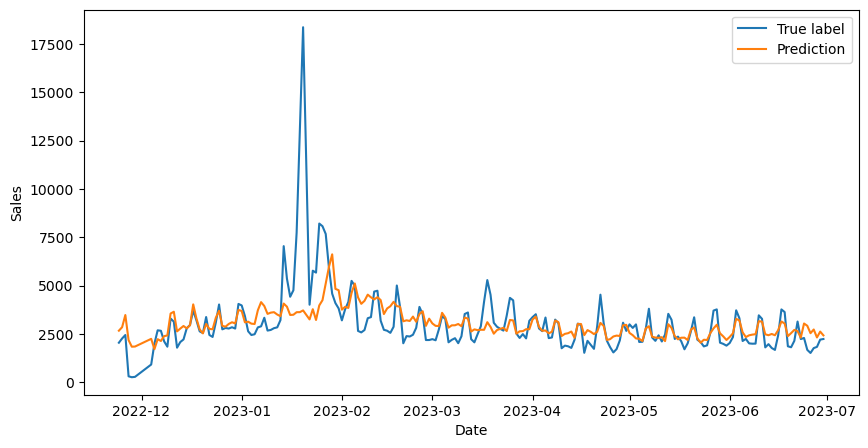

In [15]:
print(f'RMSE for Train: {train_rmse:.2f}')
print(f'RMSE for Test: {test_rmse:.2f}')

# Plot trend true label vs. prediction
plt.figure(figsize = (10,5))
sns.lineplot(data = df_predict.groupby('Date')['Sales'].sum(), label = 'True label')
sns.lineplot(data = df_predict.groupby('Date')['prediction'].sum(), label = 'Prediction')
plt.show()

In [16]:
# Since our purpose is to predict Time-series on Sales for each category, we measure RMSE in Category data point
df_predict_agg = df_predict.groupby(['Date','Category Code'], as_index = False)[['Sales','prediction']].sum()
rmse = np.sqrt(mean_squared_error(y_true = df_predict_agg['Sales'],
                                  y_pred = df_predict_agg['prediction']))
print(f'RMSE: {rmse:.2f}')

RMSE: 312.64
